In [ ]:
!pip install tensorflow

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
#load the MNIST handwritten dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
#Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 256

#batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
#define the generator model
def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

generator = make_generator_model()

In [ ]:
#define the discriminator model
def make_discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

discriminator = make_discriminator_model()

In [ ]:
#using Binary Cross entropy loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# the discriminator loss function
def discriminator_loss(real_output, fake_output):
    # discriminator must output 1 for real images
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # discriminator must output 0 for fake images
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # generator loss includes the fake outputs that discriminator classified as real
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#optimizers for both models
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    # this is the random latent vectors given as input to our generator
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # using generator to generate images
        generated_images = generator(noise, training=True)

        # feeding the generated and the actual images to the dataset
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    gen_loss_list = []
    disc_loss_list = []

    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        gen_loss_list.append(gen_loss)
        disc_loss_list.append(disc_loss)

        # Generating images for visualisation
        generate_and_save_images(generator, epoch + 1, seed)

        print(f'Epoch {epoch+1}, Generator loss: {gen_loss}, Discriminator loss: {disc_loss}')

    return gen_loss_list, disc_loss_list

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

2024-06-17 11:43:52.337369: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


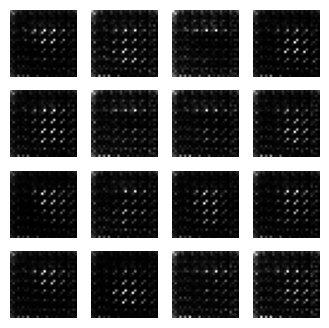

Epoch 1, Generator loss: 2.1284213066101074, Discriminator loss: 0.4807053208351135


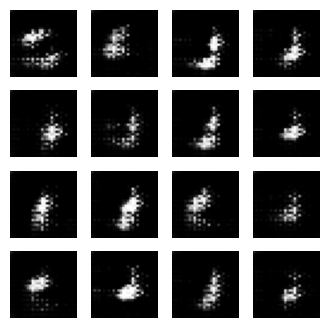

Epoch 2, Generator loss: 1.8347926139831543, Discriminator loss: 0.5634192228317261


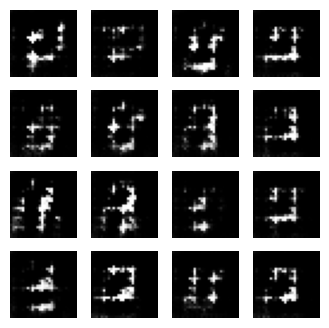

Epoch 3, Generator loss: 1.4803261756896973, Discriminator loss: 1.0458067655563354


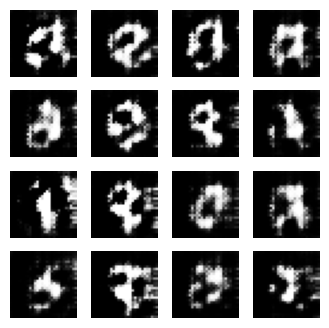

Epoch 4, Generator loss: 1.380674958229065, Discriminator loss: 0.9900462031364441


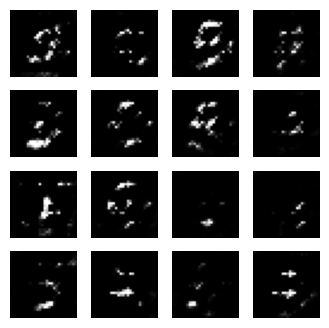

Epoch 5, Generator loss: 1.926405668258667, Discriminator loss: 0.6896324157714844


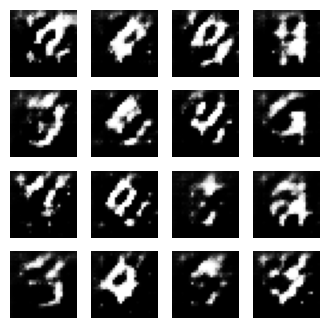

Epoch 6, Generator loss: 1.7234424352645874, Discriminator loss: 0.9134944677352905


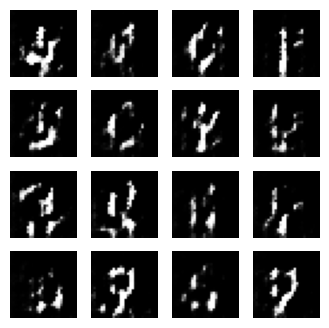

Epoch 7, Generator loss: 1.7320886850357056, Discriminator loss: 0.9033165574073792


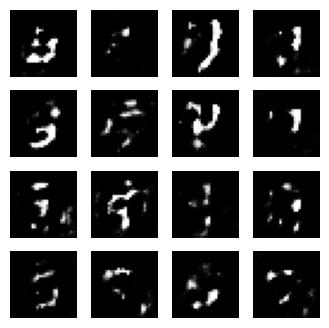

Epoch 8, Generator loss: 1.9700558185577393, Discriminator loss: 0.7902229428291321


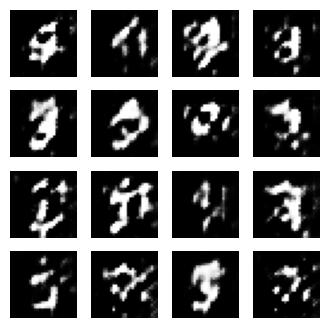

Epoch 9, Generator loss: 1.4004976749420166, Discriminator loss: 1.1064558029174805


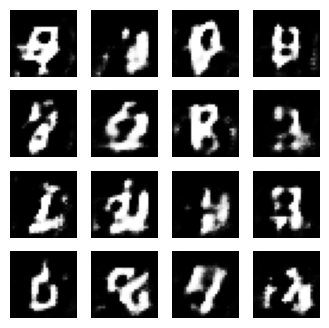

Epoch 10, Generator loss: 1.8651233911514282, Discriminator loss: 1.0066416263580322


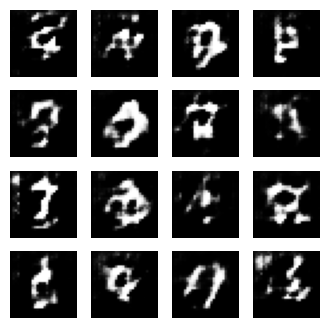

Epoch 11, Generator loss: 1.4075591564178467, Discriminator loss: 1.2253217697143555


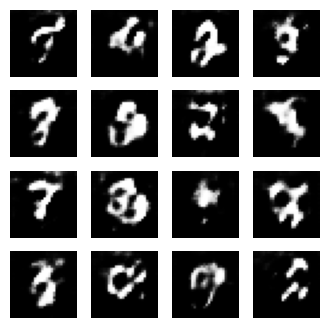

Epoch 12, Generator loss: 2.0714385509490967, Discriminator loss: 0.5667117834091187


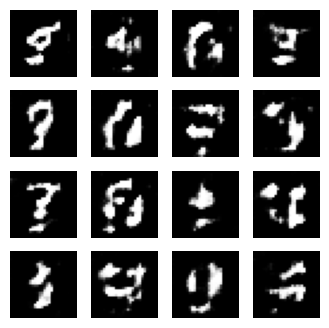

Epoch 13, Generator loss: 1.7951998710632324, Discriminator loss: 0.9722922444343567


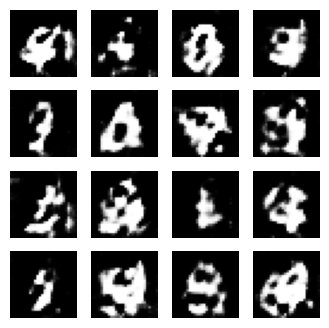

Epoch 14, Generator loss: 1.8113681077957153, Discriminator loss: 0.7836371660232544


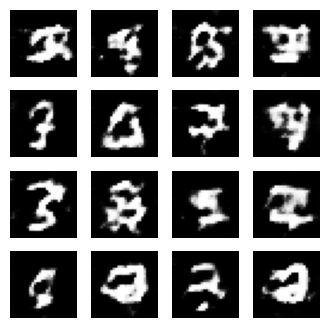

Epoch 15, Generator loss: 2.180664300918579, Discriminator loss: 0.5263863205909729


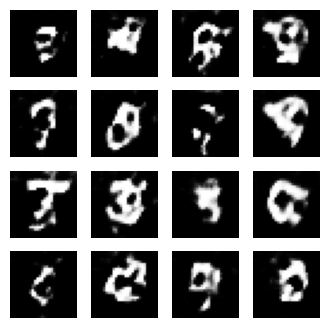

Epoch 16, Generator loss: 2.118591070175171, Discriminator loss: 0.5519602298736572


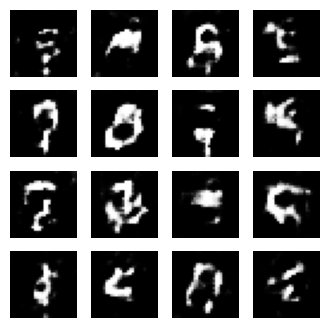

Epoch 17, Generator loss: 2.7484078407287598, Discriminator loss: 0.5105800032615662


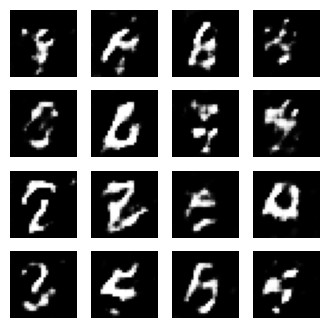

Epoch 18, Generator loss: 2.256265878677368, Discriminator loss: 0.5934264659881592


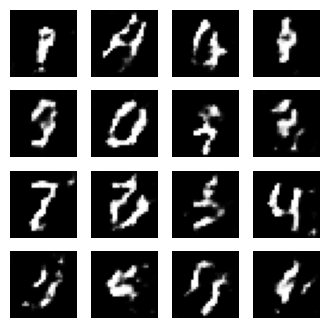

Epoch 19, Generator loss: 2.440741777420044, Discriminator loss: 0.5716515779495239


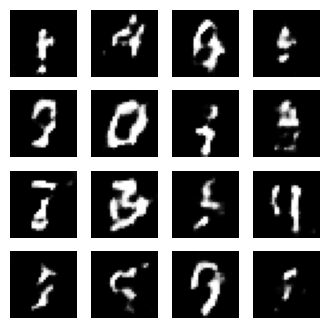

Epoch 20, Generator loss: 2.1681365966796875, Discriminator loss: 0.6907351016998291


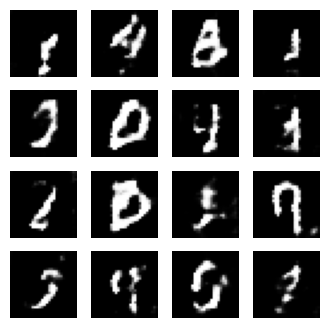

Epoch 21, Generator loss: 2.611826181411743, Discriminator loss: 0.7228257656097412


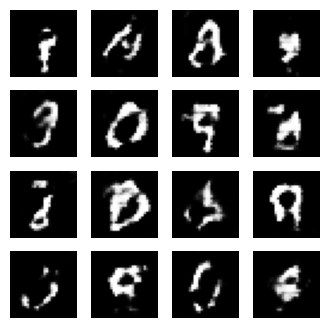

Epoch 22, Generator loss: 2.4544405937194824, Discriminator loss: 0.4797472357749939


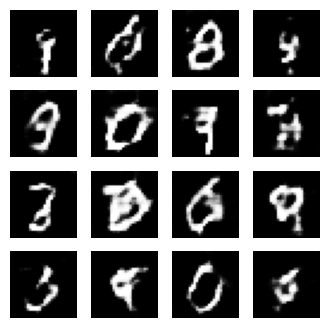

Epoch 23, Generator loss: 2.512284517288208, Discriminator loss: 0.46455955505371094


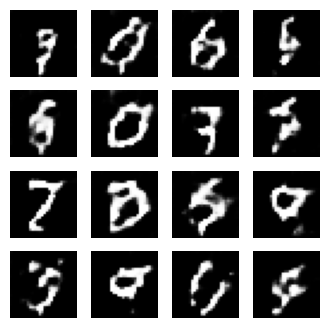

Epoch 24, Generator loss: 2.7111880779266357, Discriminator loss: 0.5885801315307617


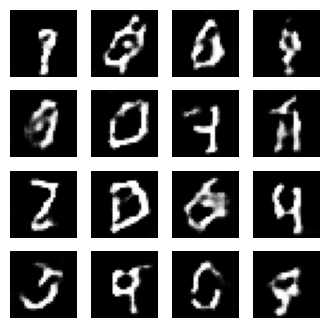

Epoch 25, Generator loss: 1.914268136024475, Discriminator loss: 1.1214962005615234


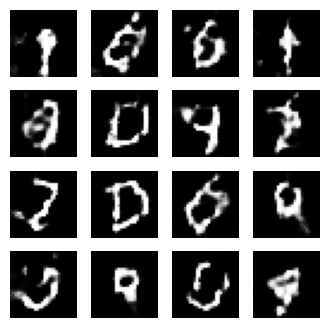

Epoch 26, Generator loss: 1.9613852500915527, Discriminator loss: 0.7108999490737915


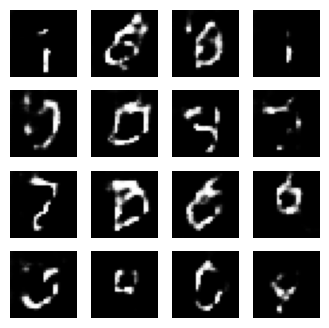

Epoch 27, Generator loss: 2.9214389324188232, Discriminator loss: 0.3676462769508362


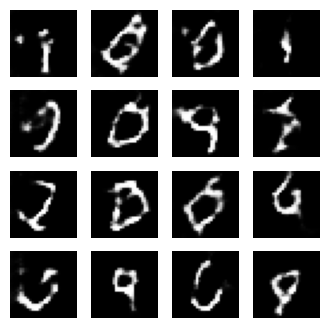

Epoch 28, Generator loss: 2.6332767009735107, Discriminator loss: 0.9793893098831177


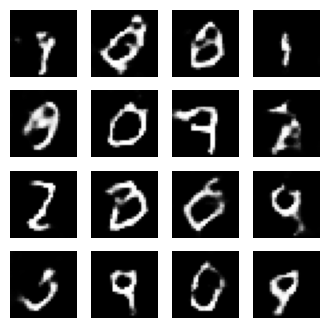

Epoch 29, Generator loss: 2.183220624923706, Discriminator loss: 0.6946712732315063


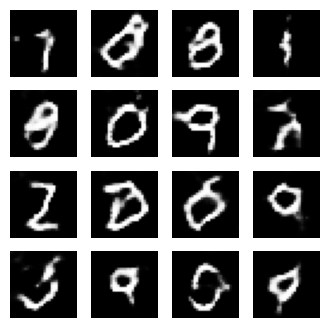

Epoch 30, Generator loss: 2.268524169921875, Discriminator loss: 0.5013375282287598


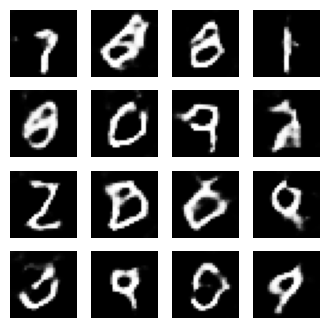

Epoch 31, Generator loss: 1.5700105428695679, Discriminator loss: 1.2141649723052979


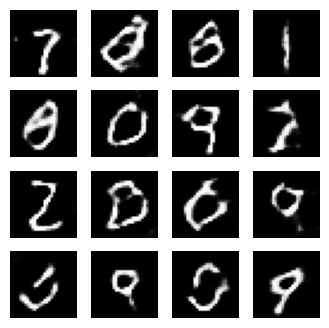

Epoch 32, Generator loss: 1.71638822555542, Discriminator loss: 0.7546563744544983


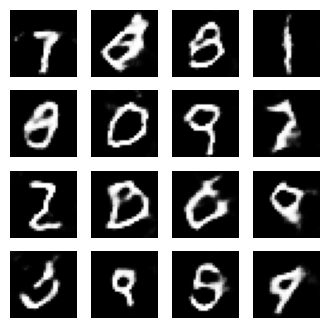

Epoch 33, Generator loss: 1.6579647064208984, Discriminator loss: 0.9557154774665833


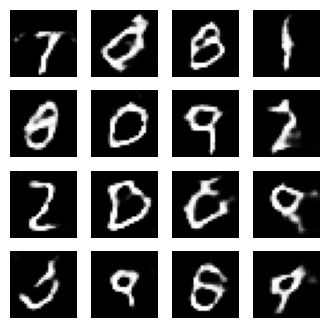

Epoch 34, Generator loss: 1.6301772594451904, Discriminator loss: 1.0495047569274902


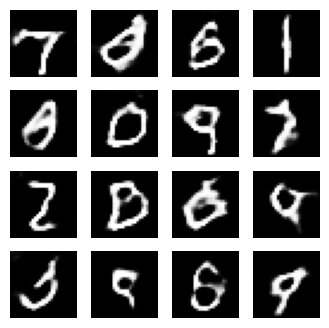

Epoch 35, Generator loss: 1.8042818307876587, Discriminator loss: 0.6952395439147949


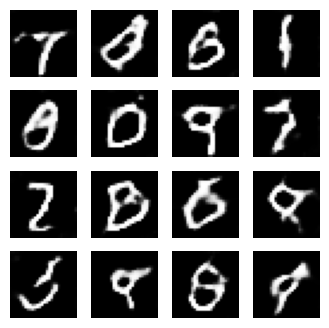

Epoch 36, Generator loss: 1.5817370414733887, Discriminator loss: 1.056220293045044


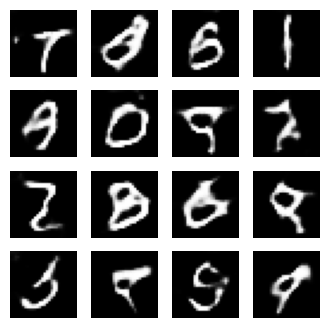

Epoch 37, Generator loss: 1.665325403213501, Discriminator loss: 1.0633286237716675


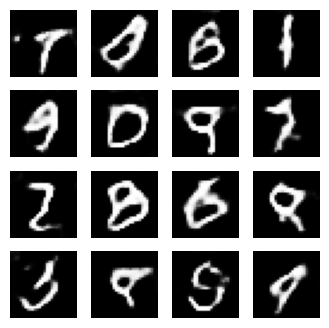

Epoch 38, Generator loss: 1.6439334154129028, Discriminator loss: 0.8637593984603882


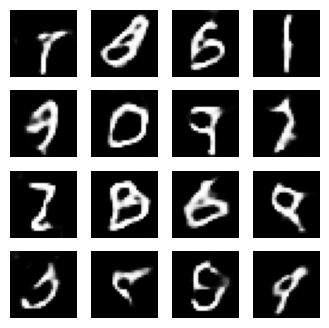

Epoch 39, Generator loss: 1.3356585502624512, Discriminator loss: 1.012725830078125


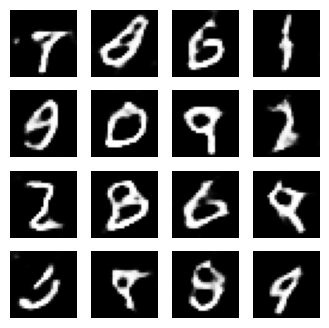

Epoch 40, Generator loss: 1.8507890701293945, Discriminator loss: 0.7860983610153198


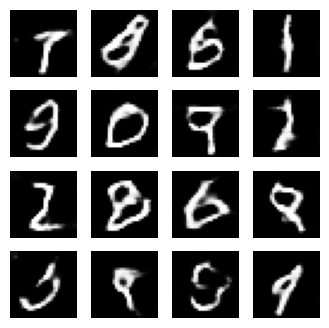

Epoch 41, Generator loss: 2.1182477474212646, Discriminator loss: 0.7533479928970337


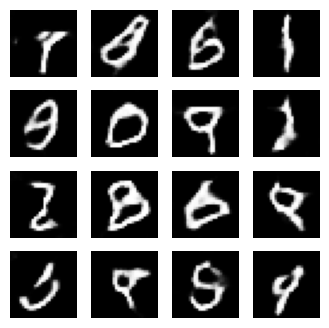

Epoch 42, Generator loss: 1.4779558181762695, Discriminator loss: 0.9509178400039673


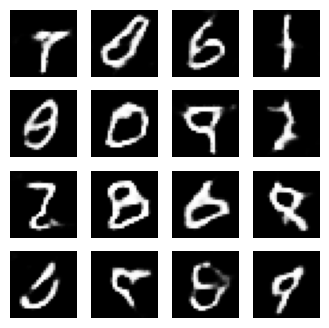

Epoch 43, Generator loss: 1.6129969358444214, Discriminator loss: 0.9087060689926147


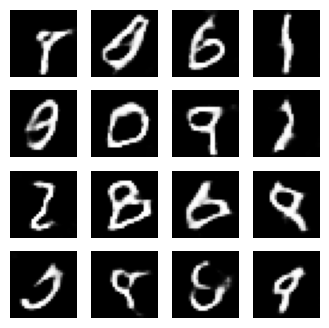

Epoch 44, Generator loss: 1.8519906997680664, Discriminator loss: 0.8541469573974609


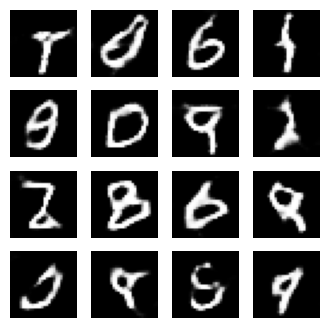

Epoch 45, Generator loss: 1.5046062469482422, Discriminator loss: 1.172396183013916


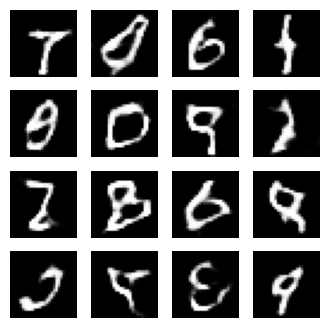

Epoch 46, Generator loss: 1.7272377014160156, Discriminator loss: 0.8036624789237976


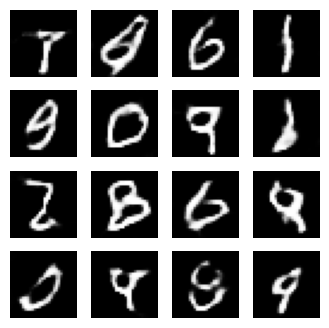

Epoch 47, Generator loss: 1.2269550561904907, Discriminator loss: 0.9010752439498901


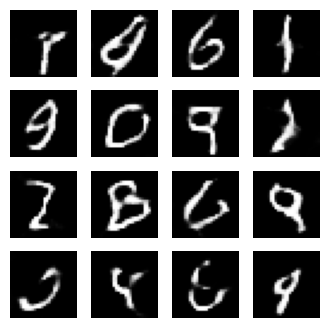

Epoch 48, Generator loss: 1.7720922231674194, Discriminator loss: 0.929366409778595


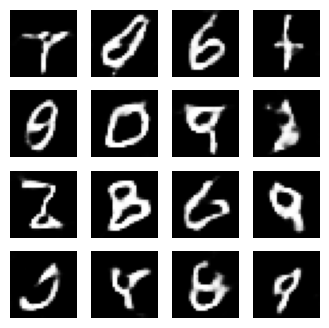

Epoch 49, Generator loss: 1.3721930980682373, Discriminator loss: 0.965984582901001


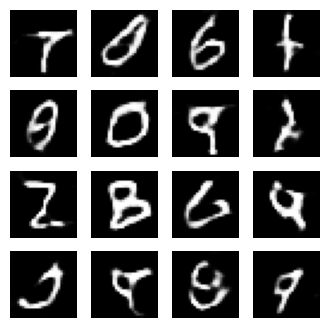

Epoch 50, Generator loss: 1.7961868047714233, Discriminator loss: 0.8103739023208618


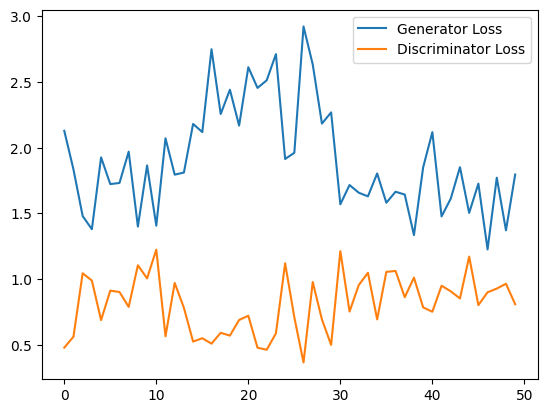

Minimum Generator Loss: 1.2269550561904907, Minimum Discriminator Loss: 0.3676462769508362


In [ ]:
gen_loss_list, disc_loss_list = train(train_dataset, EPOCHS)

plt.plot(gen_loss_list, label='Generator Loss')
plt.plot(disc_loss_list, label='Discriminator Loss')
plt.legend()
plt.show()

min_gen_loss = min(gen_loss_list)
min_disc_loss = min(disc_loss_list)
print(f'Minimum Generator Loss: {min_gen_loss}, Minimum Discriminator Loss: {min_disc_loss}')

The loss curve for the first model does not show any significant pattern, except how the generator loss was much higher than discriminator loss. The generator loss should have been decreased through the training but it kept increasing and decreasing signifying that the model is unstable.

In [ ]:
def make_generator_model_v2():
    model = Sequential()
    model.add(Dense(7*7*512, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 512)))

    # adding another upsampling layer hoping for better accuracy
    model.add(Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model
generator_v2 = make_generator_model_v2()

In [ ]:
def make_discriminator_model_v2():
    model = Sequential()
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model
discriminator_v2 = make_discriminator_model_v2()

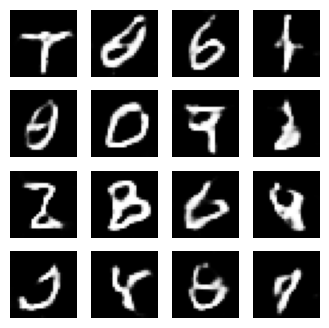

Epoch 1, Generator loss: 2.0662500858306885, Discriminator loss: 0.8267154693603516


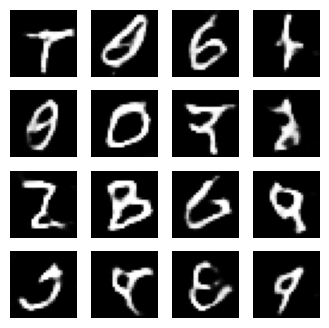

Epoch 2, Generator loss: 1.6552873849868774, Discriminator loss: 1.1191396713256836


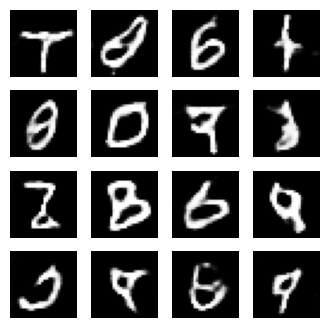

Epoch 3, Generator loss: 1.6897039413452148, Discriminator loss: 0.7876596450805664


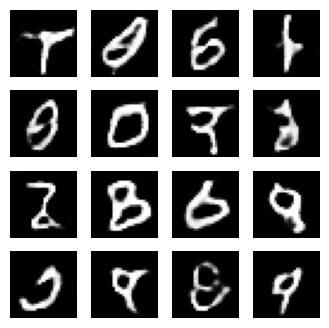

Epoch 4, Generator loss: 1.5346499681472778, Discriminator loss: 0.9334279894828796


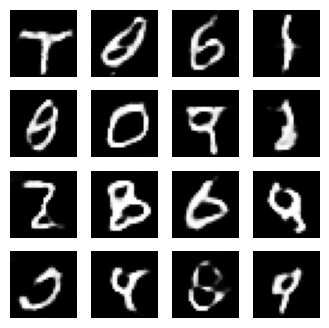

Epoch 5, Generator loss: 1.4316710233688354, Discriminator loss: 0.948512613773346


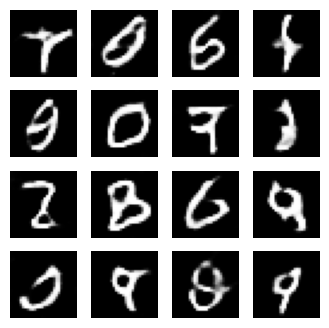

Epoch 6, Generator loss: 1.4999420642852783, Discriminator loss: 0.9436408281326294


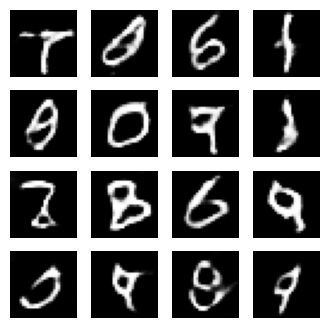

Epoch 7, Generator loss: 1.2586884498596191, Discriminator loss: 1.071315050125122


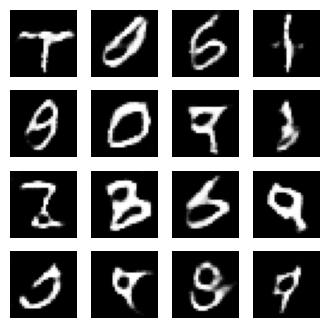

Epoch 8, Generator loss: 1.3872454166412354, Discriminator loss: 1.138777732849121


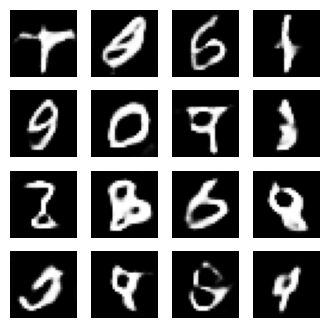

Epoch 9, Generator loss: 1.8198199272155762, Discriminator loss: 0.9659237265586853


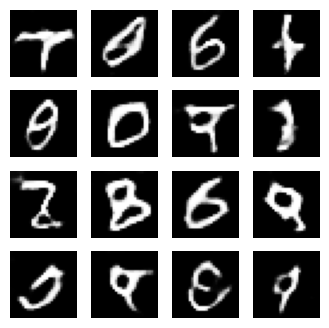

Epoch 10, Generator loss: 1.293009877204895, Discriminator loss: 0.930573582649231


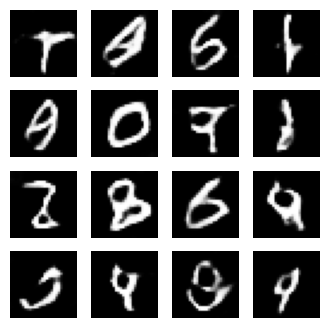

Epoch 11, Generator loss: 2.0458428859710693, Discriminator loss: 0.6644307971000671


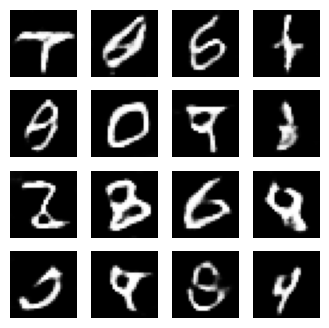

Epoch 12, Generator loss: 1.1383799314498901, Discriminator loss: 1.028613805770874


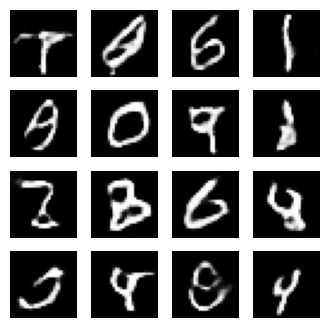

Epoch 13, Generator loss: 1.394944429397583, Discriminator loss: 0.8338135480880737


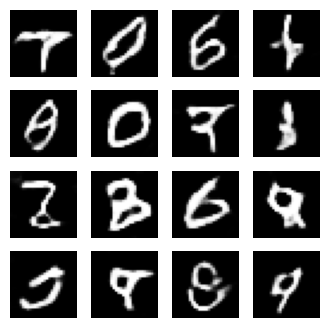

Epoch 14, Generator loss: 1.6326780319213867, Discriminator loss: 0.9369574785232544


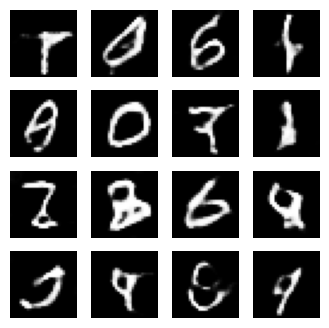

Epoch 15, Generator loss: 1.7343229055404663, Discriminator loss: 0.8117884397506714


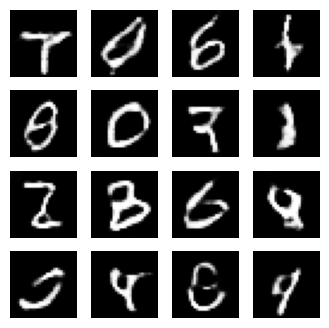

Epoch 16, Generator loss: 1.4473822116851807, Discriminator loss: 1.0566215515136719


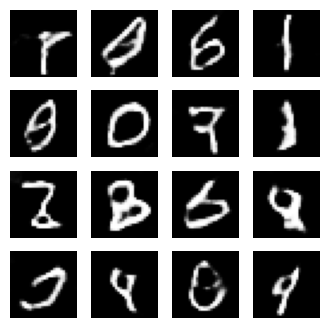

Epoch 17, Generator loss: 1.6839557886123657, Discriminator loss: 0.7974200248718262


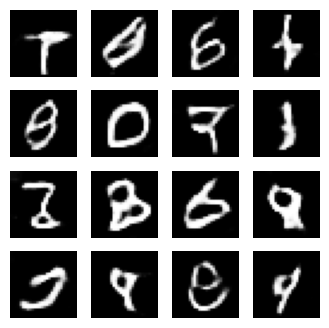

Epoch 18, Generator loss: 1.5481023788452148, Discriminator loss: 1.157205581665039


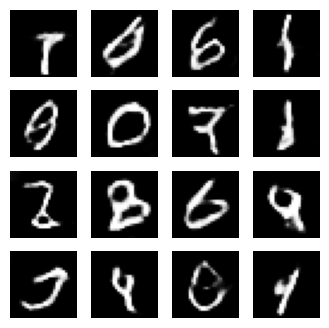

Epoch 19, Generator loss: 1.7301173210144043, Discriminator loss: 0.942547619342804


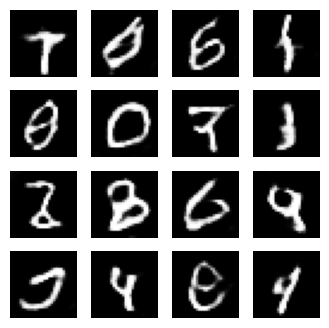

Epoch 20, Generator loss: 1.4093629121780396, Discriminator loss: 0.9423556327819824


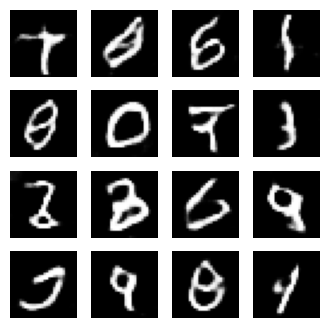

Epoch 21, Generator loss: 1.5971537828445435, Discriminator loss: 0.7958188056945801


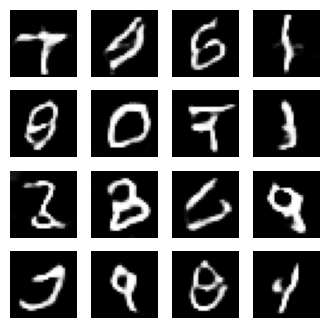

Epoch 22, Generator loss: 1.6025782823562622, Discriminator loss: 1.0468844175338745


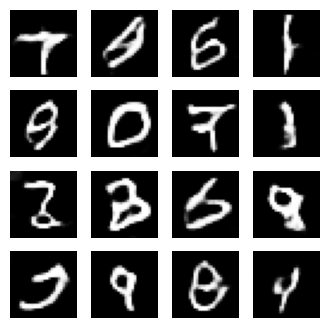

Epoch 23, Generator loss: 2.2214879989624023, Discriminator loss: 0.8767318725585938


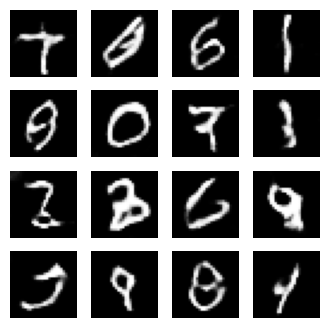

Epoch 24, Generator loss: 1.6305724382400513, Discriminator loss: 0.871966540813446


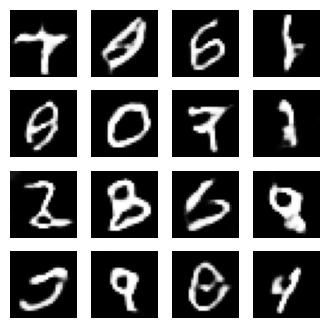

Epoch 25, Generator loss: 1.9017144441604614, Discriminator loss: 0.690819501876831


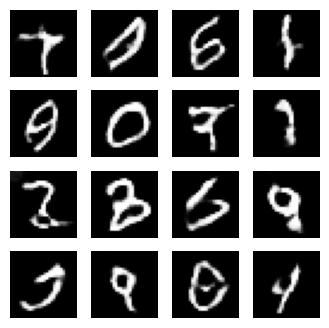

Epoch 26, Generator loss: 1.9166204929351807, Discriminator loss: 0.8247589468955994


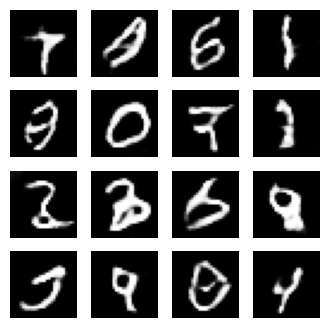

Epoch 27, Generator loss: 1.679977297782898, Discriminator loss: 0.9843719005584717


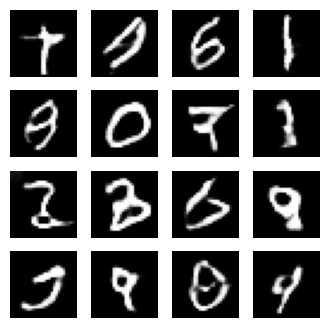

Epoch 28, Generator loss: 1.424478530883789, Discriminator loss: 0.7927553653717041


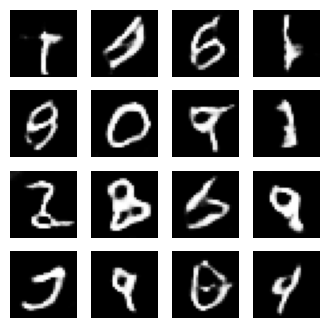

Epoch 29, Generator loss: 1.333304524421692, Discriminator loss: 0.9013867378234863


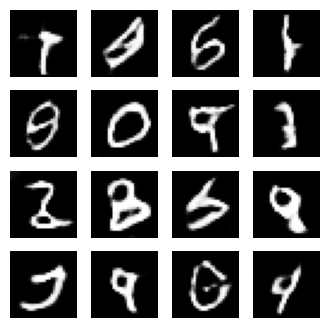

Epoch 30, Generator loss: 1.4841809272766113, Discriminator loss: 1.0499612092971802


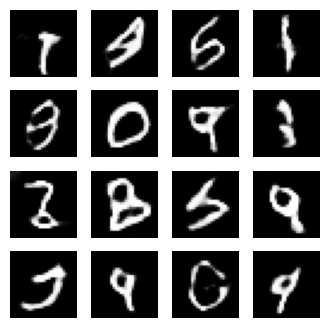

Epoch 31, Generator loss: 1.4787497520446777, Discriminator loss: 1.011101484298706


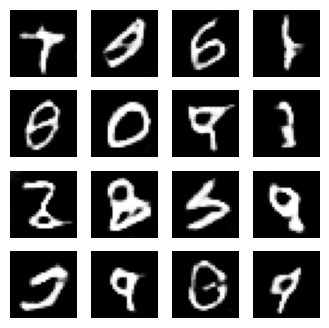

Epoch 32, Generator loss: 1.6087384223937988, Discriminator loss: 1.001593828201294


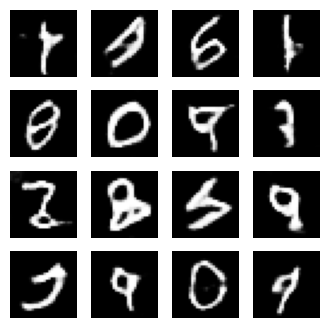

Epoch 33, Generator loss: 1.5230116844177246, Discriminator loss: 0.7461147308349609


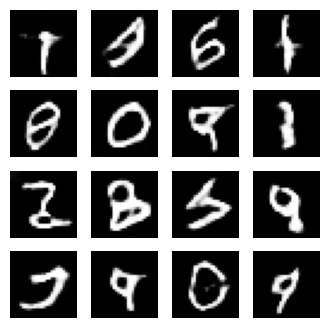

Epoch 34, Generator loss: 2.150106191635132, Discriminator loss: 0.9745954871177673


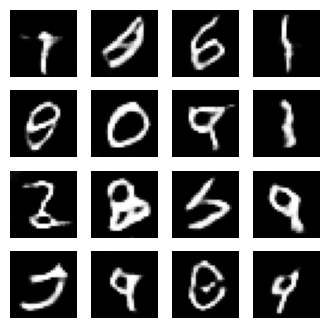

Epoch 35, Generator loss: 1.6848909854888916, Discriminator loss: 0.9517498016357422


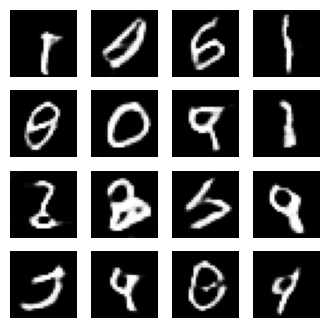

Epoch 36, Generator loss: 1.723044753074646, Discriminator loss: 0.7216024398803711


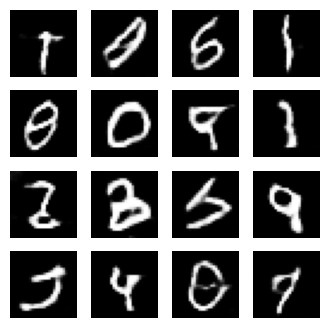

Epoch 37, Generator loss: 1.5981394052505493, Discriminator loss: 0.9817116260528564


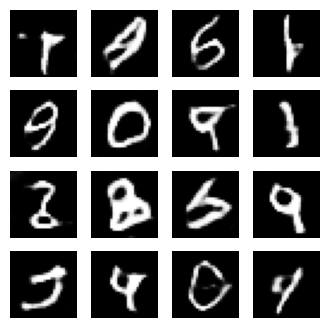

Epoch 38, Generator loss: 1.0071583986282349, Discriminator loss: 1.2996559143066406


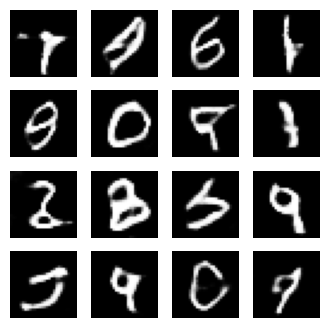

Epoch 39, Generator loss: 1.5312538146972656, Discriminator loss: 1.0842801332473755


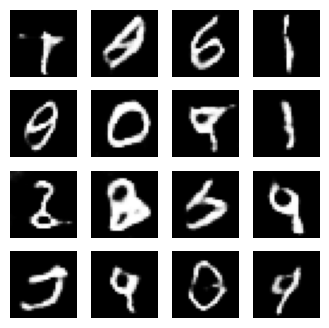

Epoch 40, Generator loss: 1.5178669691085815, Discriminator loss: 0.805815577507019


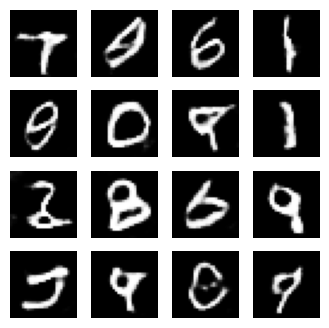

Epoch 41, Generator loss: 2.11076021194458, Discriminator loss: 1.0568511486053467


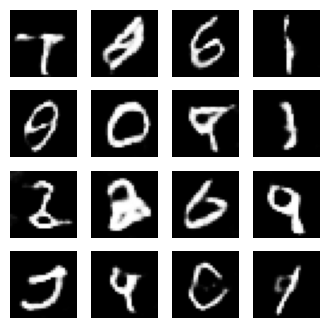

Epoch 42, Generator loss: 2.014511823654175, Discriminator loss: 0.629143238067627


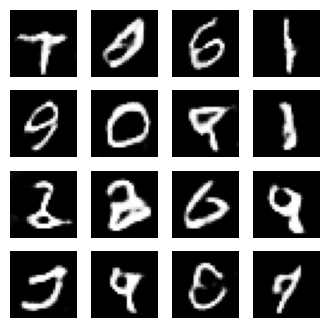

Epoch 43, Generator loss: 1.976477861404419, Discriminator loss: 1.002596139907837


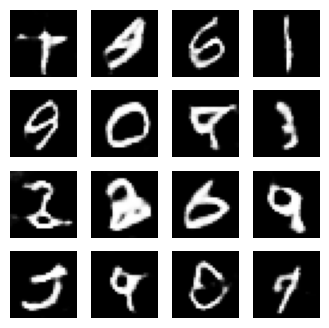

Epoch 44, Generator loss: 2.5066983699798584, Discriminator loss: 0.7803632020950317


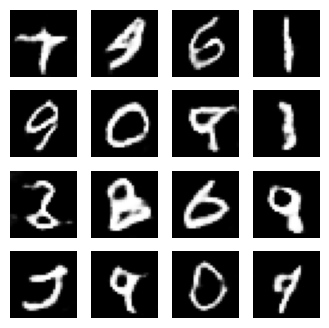

Epoch 45, Generator loss: 2.5281882286071777, Discriminator loss: 0.8592849969863892


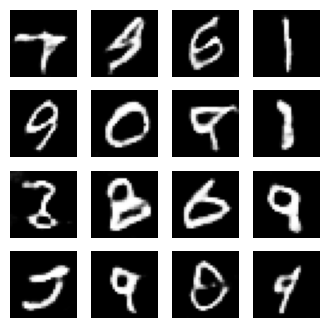

Epoch 46, Generator loss: 1.478732943534851, Discriminator loss: 0.8022487759590149


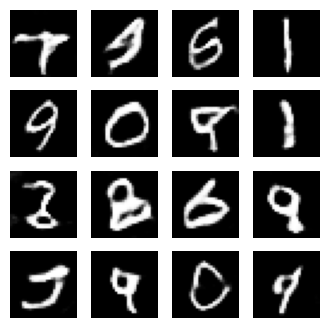

Epoch 47, Generator loss: 1.79923415184021, Discriminator loss: 0.8941874504089355


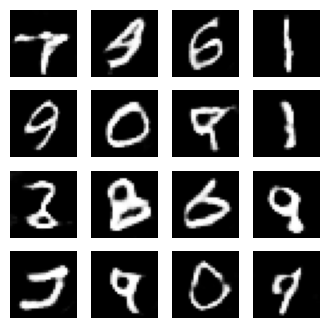

Epoch 48, Generator loss: 1.3768283128738403, Discriminator loss: 1.4867057800292969


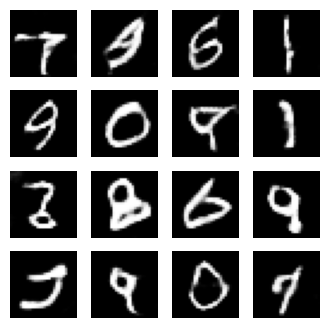

Epoch 49, Generator loss: 1.9441730976104736, Discriminator loss: 0.9429225921630859


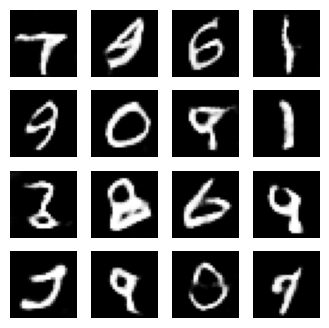

Epoch 50, Generator loss: 1.4737952947616577, Discriminator loss: 0.9252222180366516


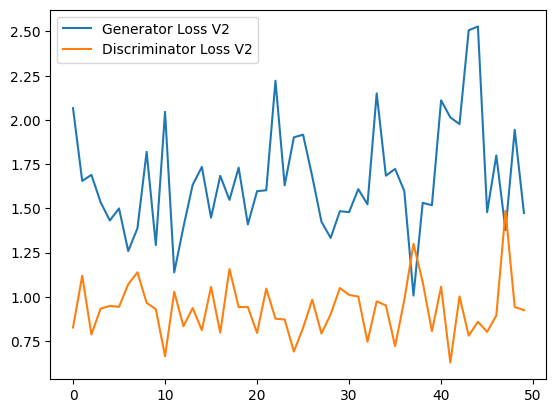

Minimum Generator Loss V2: 1.0071583986282349, Minimum Discriminator Loss V2: 0.629143238067627


In [ ]:
gen_loss_list_v2, disc_loss_list_v2 = train(train_dataset, EPOCHS)

plt.plot(gen_loss_list_v2, label='Generator Loss V2')
plt.plot(disc_loss_list_v2, label='Discriminator Loss V2')
plt.legend()
plt.show()

min_gen_loss_v2 = min(gen_loss_list_v2)
min_disc_loss_v2 = min(disc_loss_list_v2)
print(f'Minimum Generator Loss V2: {min_gen_loss_v2}, Minimum Discriminator Loss V2: {min_disc_loss_v2}')

For this model also the loss curves did not follow any pattern. The generator loss was in general lower than the generator loss in previous model and the discriminator loss was higher, maybe due to the adversarial nature of GANs

By adding another layer to the DCGAN Model, we got approximately 0.22 lower Minimum Generator Loss but a higher Minimum Discriminator loss.There's a slight improvement in the last images generated by the new model as compared to the old model. 7, 9 and 1 have become slightly more recognizable. Both the models were very unstable during training resulting in bad loss curves. I did try some techniques to stabilize GANs mentioned online such as adding BatchNormalization layers to both Generator and Discriminator, changing the loss function and flipping the real and fake images but the stability did not improve instead the losses got increased and generated images became worse.


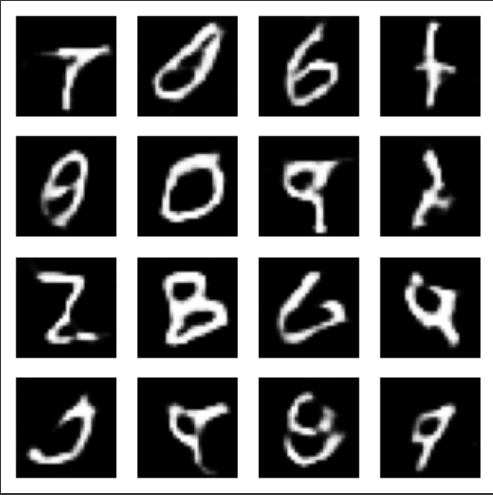


Image Generated by Initial model on 50th iteration.



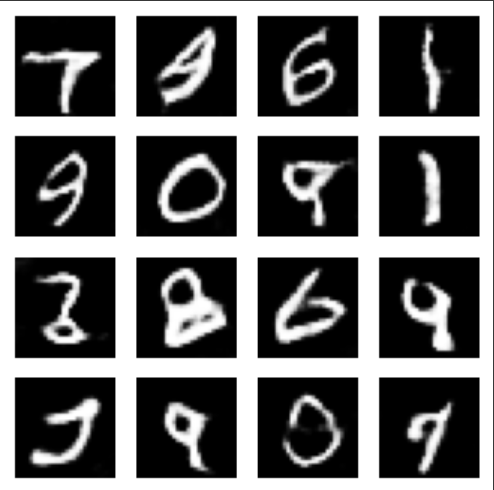

Image generated by the second model on 50th iteration.